<div class="alert alert-block alert-info">
    <b>Projet 6 | Classifiez automatiquement des biens de consommation<br></b>
    <p style="color:#8B0000;">
        Notebook |  Analyse Exploratoire & Clustering</p>
</div>

# | Présentation du projet et démarche envisagée

## | Projet

Je suis Data Scientist au sein de l’entreprise "Place de marché”, qui souhaite lancer une marketplace e-commerce.

<img src="logo.png" style="width:450px;height:270px"/>

Sur la place de marché, des vendeurs proposent des articles à des acheteurs en postant une **photo** et une **description**.

Pour l'instant, l'**attribution de la catégorie d'un article** est effectuée **manuellement** par les vendeurs, et est donc peu fiable. De plus, le volume des articles est pour l’instant très petit.

Pour rendre l’expérience utilisateur des vendeurs (faciliter la mise en ligne de nouveaux articles) et des acheteurs (faciliter la recherche de produits) la plus fluide possible, et dans l'optique d'un passage à l'échelle, il devient nécessaire d'**automatiser cette tâche**.

Linda, Lead Data Scientist, me demande d'**étudier la faisabilité** d'un **moteur de classification** des articles en différentes catégories, avec un niveau de précision suffisant. Je dois **analyser le jeu de données** en réalisant un **prétraitement des descriptions des produits et des images**, une **réduction de dimension**, puis un **clustering**. 

Afin d’extraire les features texte, il sera nécessaire de mettre en œuvre :
-  deux approches de type “bag-of-words”, comptage simple de mots et Tf-idf ;
-  une approche de type word/sentence embedding classique avec Word2Vec (ou Glove ou FastText) ;
-  une approche de type word/sentence embedding avec BERT ;
-  une approche de type word/sentence embedding avec USE (Universal Sentence Encoder)

On me fournit un **exemple de mise en œuvre** des approches demandées pour le traitement des **features texte** sur un autre dataset et on m’invite à l’utiliser comme **point de départ**.

Afin d’extraire les **features image**, il sera nécessaire de mettre en œuvre :
-  un algorithme de type SIFT / ORB / SURF ;
-  un algorithme de type CNN Transfer Learning.

## | Démarche envisagée

Je vais **identifier** les **features source** et les **labels cibles** à obtenir, puis rechercher les meilleurs **extractors de texte et d'image** pour parvenir à la classification automatique la plus proche de celle d'origine effectuée manuellement :

1. Sélection des **champs utiles** et **analyse exploratoire** pour la sélection des **features**.
2. Prétraitement du texte: nettoyage, lemmatization
3. Recherche du **meilleur** feature extractor du **traitement de texte** (critère de l'ARI Score)
4. Recherche du **meilleur** feature extractor du **traitement d'image**  (critère de l'ARI Score)
5. **Concaténation** des deux features extractor | 3 options possibles:
	- soit avec l'image on **améliore** les performances
	- soit l'ajout **ne sert à rien** (capé par le NLP)
	- soit les performances sont **dégradées** avec l'image<br>
    
    
6. Test de l'**intérêt d'une ACP**. Estimer le meilleur moment pour l'intégrer : étape Texte, étape Image, étape concaténation.

Pour les features extractor du traitement de texte, je m'appuierai sur l'**exemple de traitement fourni** par Linda pour construire mon notebook. 

# | Import des packages, fonctions et paramétrage initial

Notebook variables reset for each complete execution of this code :

In [1]:
%reset -f

## | Vérification de la version de Python

In [2]:
!python -V

Python 3.9.12


## | Environnement de Keras TensorFlow

In [3]:
import os
os.environ["TF_KERAS"]='1'

## | Installation des nouveaux packages nécessaires

In [4]:
# %pip install nltk

In [5]:
# %pip install tensorflow

In [6]:
# %pip install gensim

In [7]:
# %pip install transformers

In [8]:
# %pip install sacremoses

In [9]:
# %pip install tensorflow_hub

In [10]:
# %pip install tensorflow_text

In [11]:
# installing yellowbrick.cluster
# !pip install yellowbrick

## | Import des librairies utiles au projet + nltk

In [12]:
# Modules classiques d'analyse exploratoire:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
from pandas_profiling import ProfileReport
import missingno as msno
import scipy.stats as stats
import chart_studio as cs
import plotly.offline as po
import plotly.graph_objs as gobj
import re

# Mathématiques
import math

# Manipulation fichiers et Interaction avec l'os / notebook
from os import listdir
import csv
import requests
import warnings
import json
import autopep8
import pickle
import logging

# Manipulations d'images
import cv2

# Manipulations temporelles
import datetime as dt
# from tqdm import tqdm
# from tqdm.notebook import tqdm, trange
import time

# Feature engineering
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

# clustering & metrics
from sklearn import cluster, metrics
from sklearn import manifold, decomposition
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# Modelling
from sklearn.cluster import KMeans

# Tokenizer
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

# Stop words
from nltk.corpus import stopwords

# Lemmatizer (base d'un mot)
from nltk.stem import WordNetLemmatizer

# création bag of words (CountVectorizer et Tf-idf)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Natural Language Processing modeling
import gensim

# Bert
import transformers
from transformers import *

# conception réseau de neurones & API prototypage rapide | tensorflow & keras
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K
import tensorflow_hub as hub
import tensorflow_text

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# VGG16
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input
from keras.models import Model

In [13]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\sebas\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [14]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sebas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sebas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [16]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sebas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## | Vérification des versions de package disponibles

In [17]:
!pip list

Package                           Version
--------------------------------- ------------
absl-py                           1.2.0
appdirs                           1.4.4
argon2-cffi                       21.3.0
argon2-cffi-bindings              21.2.0
asttokens                         2.0.5
astunparse                        1.6.3
attrs                             21.4.0
autopep8                          1.6.0
backcall                          0.2.0
beautifulsoup4                    4.11.1
bleach                            4.1.0
branca                            0.5.0
bs4                               0.0.1
cachetools                        5.2.0
certifi                           2022.6.15
cffi                              1.15.0
charset-normalizer                2.1.0
chart-studio                      1.1.0
click                             8.1.3
colorama                          0.4.5
cycler                            0.11.0
Cython                            0.29.28
debugpy            

## | Mise en page et réglages divers du notebook

In [18]:
# Modification des affichages de colonnes, lignes et largeurs de colonnes pour bien visualiser les colonnes
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 1000)

# Affichage avec la bibliothèque graphique intégrée à Notebook:
%matplotlib inline

# Format des graphiques seaborn
sns.set_theme(style="whitegrid")

## | Fonctions utiles au projet 

### | Traitement données colonnes | Texte

In [19]:
def clean_and_split(to_split):
    """Fonction qui nettoie les valeurs d'une colonne
    'to_split' et la divise en plusieurs colonnes
    """
    to_split = to_split.str.strip('[]"')
    return to_split.str.split('>>', n=3, expand=True)
#     return to_split

In [20]:
def clean_space(to_clean):
    """Fonction qui supprime les espaces d'une colonne
    'to_split' au début et à la fin de chaque ligne
    """
    to_clean = to_clean.str.strip()
    return to_clean

### | Préparation données textuelles | Communes

In [21]:
def tokenizer_fct(sentence) :
    # print(sentence)
    sentence_clean = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ')
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens

# Stop words
stop_w = list(set(stopwords.words('english'))) + ['[', ']', ',', '.', ':', '?', '(', ')']

def stop_word_filter_fct(list_words) :
    filtered_w = [w for w in list_words if not w in stop_w] # on filtre selon la liste stop_w
    filtered_w2 = [w for w in filtered_w if len(w) > 2] # on retire les mots composés d'1 ou 2 lettres
    return filtered_w2

# lower case et alpha
def lower_start_fct(list_words) :
    lw = [w.lower() for w in list_words if (not w.startswith("@")) 
    #                                   and (not w.startswith("#"))
                                       and (not w.startswith("http"))]
    return lw

# Lemmatizer (base d'un mot)
def lemma_fct(list_words) :
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w

# Fonction de préparation du texte pour le bag of words (Countvectorizer et Tf_idf, Word2Vec)
def transform_bow_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

# Fonction de préparation du texte pour le bag of words avec lemmatization
def transform_bow_lem_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text

# Fonction de préparation du texte pour le Deep learning (USE et BERT)
def transform_dl_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
#    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(word_tokens)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

### | Préparation données textuelles | BERT

In [22]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features - diminuer la batch_size si mémoire pleine
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

### | Préparation données textuelles | USE

In [23]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

### | Préparation données images

In [24]:
def list_fct(name) :
    """Fonction qui renvoie la liste des noms
    d'image dans l'ordre des indices du dataframe 'data'
    et pour la valeur de cat_1 égale à 'name'
    """
    list_image_name = [list_photos[i] for i in range(len(data)) if data["cat_1"][i]==name]
    return list_image_name

In [25]:
def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist

### | Calcul et visualisation T-SNE / ARI

In [26]:
# Calcul Tsne (init PCA), détermination des clusters et calcul ARI entre vraies catégories et n° de clusters
def ARI_fct(features) :
    time1 = time.time()
    num_labels=len(l_cat)
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, 
                                 init='pca', learning_rate=200, random_state=44)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données après Tsne 
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=44)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_tsne, cls.labels_


# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI) :
    fig = plt.figure(figsize=(15,6))
    
    # on représente les individus par catégories réelles
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Categorie")
    plt.title('Représentation des produits par catégories réelles')
    
    # on représente les individus par catégories selon le modèle d'extraction de features (output = labels)
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des produits par clusters')
    
    plt.show()
    print("ARI : ", ARI)

### | Calcul et visualisation Silhouette Score

In [27]:
# visualize clustering model silhouette score 
# (need to add seed or random state for reproductibility)
def silh_fct(features) :
    time1 = time.time()
    model = KMeans(7, random_state=42)
    visualizer = SilhouetteVisualizer(model)
    visualizer.fit(features)    # Fit the data to the visualizer
    visualizer.poof()    # Draw/show/poof the data
    time2 = np.round(time.time() - time1,0)
    print("Silhouette Score : ", round(visualizer.silhouette_score_,4), "time : ", time2)
    
    return visualizer.silhouette_score_

# | Texte | Chargement et préparation des données

In [28]:
data = pd.read_csv('flipkart_com-ecommerce_sample_1050.csv')

In [29]:
data.shape

(1050, 15)

In [30]:
data.head(2).T

0  \
uniq_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              55b85ea15a1536d46b7190ad6fff8ce7   
crawl_timestamp                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             2016-04-30 03:22:56 +0000   
product_url                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [31]:
data.dtypes

uniq_id                     object
crawl_timestamp             object
product_url                 object
product_name                object
product_category_tree       object
pid                         object
retail_price               float64
discounted_price           float64
image                       object
is_FK_Advantage_product       bool
description                 object
product_rating              object
overall_rating              object
brand                       object
product_specifications      object
dtype: object

In [32]:
data.describe(include=[object])

uniq_id            crawl_timestamp                                                                                                                 product_url                                                product_name                                          product_category_tree               pid                                 image  \
count                               1050                       1050                                                                                                                        1050                                                        1050                                                           1050              1050                                  1050   
unique                              1050                        149                                                                                                                        1050                                                        1050                                                            642              1050                                  1050   
top     55b85ea15a1536d46b7190ad6fff8ce7  2015-12-01 12:40:44 +0000  http://www.flipkart.com/elegance-polyester-multicolor-abstract-eyelet-door-curtain/p/itmeg7bkzdgthcts?pid=CRNEG7BKMFFYHQ8Z  Elegance Polyester Multicolor Abstract Eyelet Door Curtain  ["Home Furnishing >> Bed Linen >> Blankets, Quilts & Dohars"]  CRNEG7BKMFFYHQ8Z  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
freq                                   1                        150                                                                                                                           1                                                           1                                                             56                 1                                     1   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         description  \
count                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

La colonne **'product_category_tree'** contient des élements textuels qui permettront répondre à la demande de Linda : étudier la faisabilité de l'**attribution automatique de la catégorie** d'un article.<br>

En effet, cette colonne contient les étiquettes finales auxquelles il faudra attribuer automatiquement les produits, sur base de leur description et d'une image.

Je vais analyser les valeurs de cette colonne, mais pour cela je dois la traiter avec la fonction créée à cet effet : **clean_and_split**.

In [33]:
data[['cat_1', 'cat_2', 'cat_3', 'cat_4']] = clean_and_split(data['product_category_tree'])

In [34]:
data.head(2).T

0  \
uniq_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              55b85ea15a1536d46b7190ad6fff8ce7   
crawl_timestamp                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             2016-04-30 03:22:56 +0000   
product_url                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

La fonction a bien divisé la colonne 'product_category_tree' en 4 colonnes : je vais maintenant terminer avec un **nettoyage des espaces** et **étudier les 3 premiers niveaux** pour **identifier celui à utiliser** pour la classification.

In [35]:
for cat in ['cat_1', 'cat_2', 'cat_3']:
    data[cat] = clean_space(data[cat])
    print(cat,' :', len(data[cat].unique()),'values')
    print(data[cat].unique())

cat_1  : 7 values
['Home Furnishing' 'Baby Care' 'Watches' 'Home Decor & Festive Needs'
 'Kitchen & Dining' 'Beauty and Personal Care' 'Computers']
cat_2  : 62 values
['Curtains & Accessories' 'Baby Bath & Skin' 'Bed Linen' 'Wrist Watches'
 'Living Room Furnishing' 'Bath Linen' 'Candles & Fragrances'
 'Tableware & Cutlery' 'Lighting' 'JMD Home Furnishing' 'Infant Wear'
 "Kripa's Home Furnishing" 'Hair Care' 'Coffee Mugs' 'Network Components'
 'Tablet Accessories' 'Cookware' 'Laptop Accessories' 'Makeup'
 'Combos and Kits' 'Feeding & Nursing' 'Baby Bedding'
 'Kitchen & Dining Linen' 'Containers & Bottles'
 'Consumables & Disposables' 'Wall Decor & Clocks'
 'Table Decor & Handicrafts' 'Flowers, Plants & Vases' 'Software'
 'Showpieces' 'Furniture & Furnishings' 'Decorative Lighting & Lamps'
 'Baby Grooming' 'Computer Peripherals' 'Cushions, Pillows & Covers'
 'Storage' 'Health Care' 'Body and Skin Care' 'Kitchen Tools'
 'TRUE Home Decor & Festive Needs' 'Living' 'Showpiece' 'Bar & Glasswa

J'ajoute un **label numérique** correpsondant à chaque valeur de cat_1.

In [36]:
le = preprocessing.LabelEncoder()
data["label"] = le.fit_transform(data["cat_1"])

In [37]:
cat_1_num = list(data.label.unique())
cat_1_num

[4, 0, 6, 3, 5, 1, 2]

In [38]:
data.head(3).T

0  \
uniq_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              55b85ea15a1536d46b7190ad6fff8ce7   
crawl_timestamp                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             2016-04-30 03:22:56 +0000   
product_url                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

# | Texte | Analyse exploratoire

## | Analyse des manquants

Remarques sur les manquants : 
-  La colonne **cat_4** est incomplète (manque 1/3). Elle contient la partie la plus détaillée de la hiérarchie produit, elle ne sera **pas valorisée** dans cette classification automatique.
-  La colonne **cat_3** présente quelques manquants, mais il est possible de supprimer les **3 lignes concernées** avant de modéliser.
-  La colonne **brand** est également incomplète (manque 1/3) et **ne servira probablement pas non plus** à la classification, mais pourra servir à l'analyse exploratoire.

In [39]:
data.isnull().sum(axis=0).sort_values(ascending=False)

cat_4                      371
brand                      338
cat_3                        3
retail_price                 1
discounted_price             1
product_specifications       1
uniq_id                      0
product_rating               0
cat_2                        0
cat_1                        0
overall_rating               0
description                  0
crawl_timestamp              0
is_FK_Advantage_product      0
image                        0
pid                          0
product_category_tree        0
product_name                 0
product_url                  0
label                        0
dtype: int64

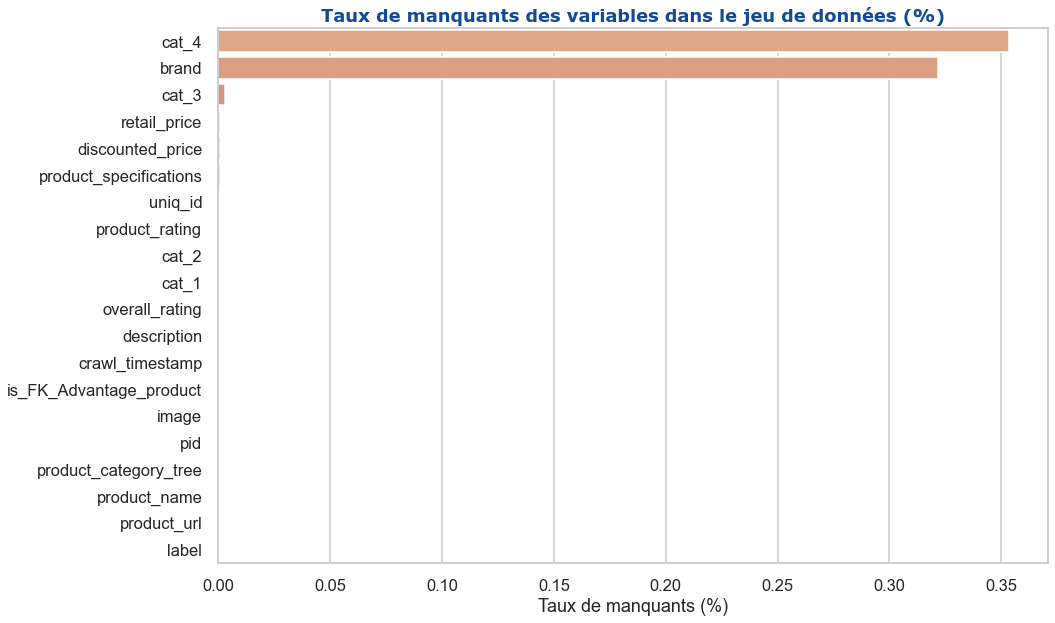

In [40]:
sns.set_context("talk")  # ('notebook', 'paper', 'talk', 'poster')

vars = pd.DataFrame(data.isnull().mean(), columns=['Taux_de_Null']).sort_values(
    by='Taux_de_Null', ascending=False)
fig = plt.figure(figsize=(15, 9))

font_title = {'family': 'verdana',  # serif, arial, verdana, times new roman
              'color':  '#114b98',
              'weight': 'bold',
              'size': 18,
              }

sns.barplot(x=vars.Taux_de_Null, y=vars.index, data=vars, palette="flare")

# Seuil pour suppression des variables
# plt.axvline(x=max_threshold, linewidth=2, color = 'r')
# plt.text(max_threshold+0.1, 20, 'Seuil de suppression des variables', fontsize = 16, color = 'r')

plt.title("Taux de manquants des variables dans le jeu de données (%)",
          fontdict=font_title)
plt.xlabel("Taux de manquants (%)")

fig.tight_layout()

plt.show()

## | Analyse des features

A ce stade, on a constaté :

-  cat_1 : 7 valeurs (peu détaillé= bon pour une analyse de faisabilité / POC)
-  cat_2 : 62 valeurs (semblerait un candidat pour les labels cible finaux)
-  cat_3 : 242 valeurs uniques (trop de valeurs différentes)
-  Aucun manquant constaté dans les colonnes **cat_1, description et image** : ce seront donc respectivement mes **labels, features texte et image**. Je pourrai décider ultérieurement de conserver **cat_2** (complet également) et **product name** pour vérification en cas de doute, mais je les supprime pour le moment.

### | Tri des features utiles

In [41]:
cols_to_keep = ['cat_1', 'image', 'description', 'label', 'cat_2', 'brand']

In [42]:
data = data.loc[:, cols_to_keep]

In [43]:
data.head(2).T

0  \
cat_1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     Home Furnishing   
image                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                55b85ea15a1536d46b7190ad6fff8ce7.jpg   
description  Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you get the right amount of sunlight.,Specifications of Elegance Polyester Multicolor Abstract Eyelet Door Curta

In [44]:
data.shape

(1050, 6)

In [45]:
print('On a maintenant une base de données contenant', data.shape[0],
      'produits répartis en', len(data['cat_1'].unique()), 'catégories cibles.')

On a maintenant une base de données contenant 1050 produits répartis en 7 catégories cibles.


### | Analyse données qualitatives

J'ai bien identifié les données source :
-  champ **description** | données textuelles
-  champ **image** | données image

et les étiquettes cibles :
-  champ **cat_1**

Passons maintenant à la recherche du meilleur extractor du **traitement d'image**.

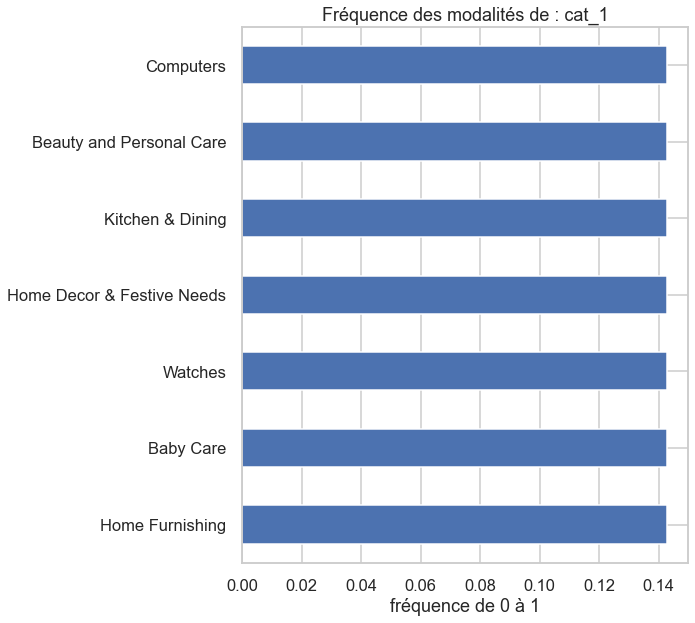

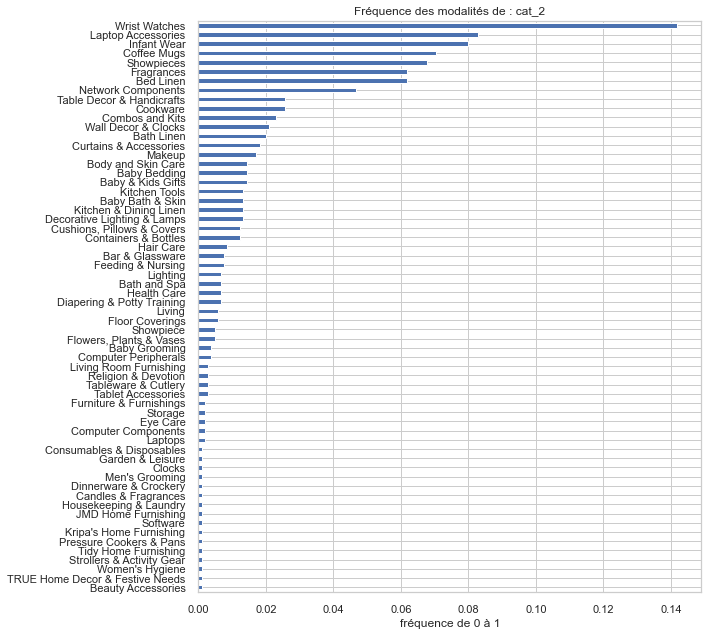

In [46]:
for column in ['cat_1', 'cat_2']:
    chaine = 'Fréquence des modalités de : ' + column
    plt.figure(figsize=(10, 9))
    data[column].value_counts(normalize=True, ascending=True).plot(
        kind='barh')  # normalize pour avoir les fréquences
    plt.title(chaine)
    plt.xlabel("fréquence de 0 à 1")
    plt.tight_layout()

    # scaling automatique selon type de présentation ('notebook', 'paper', 'talk', 'poster')
    sns.set_context("notebook")

    plt.show()

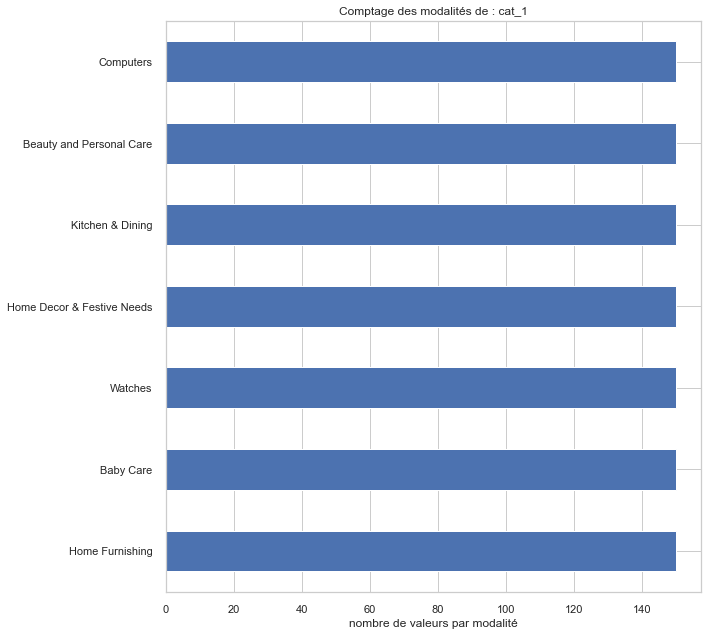

In [47]:
for column in ['cat_1']:
    chaine = 'Comptage des modalités de : ' + column
    plt.figure(figsize=(10, 9))
    data[column].value_counts(normalize=False, ascending=True).plot(
        kind='barh')  # normalize pour avoir les fréquences
    plt.title(chaine)
    plt.xlabel("nombre de valeurs par modalité")
    plt.tight_layout()

    # scaling automatique selon type de présentation ('notebook', 'paper', 'talk', 'poster')
    sns.set_context("notebook")

    plt.show()

Les distributions ci-dessus **confirment le choix de cat_1** pour l'étude de faisabilité.<br>
En effet, on constate qu'**une pré-sélection égale de 150 individus par modalité (7 modalités) de la catégorie 1** a été réalisée pour constituer l'échantillon de **1050 individus**.

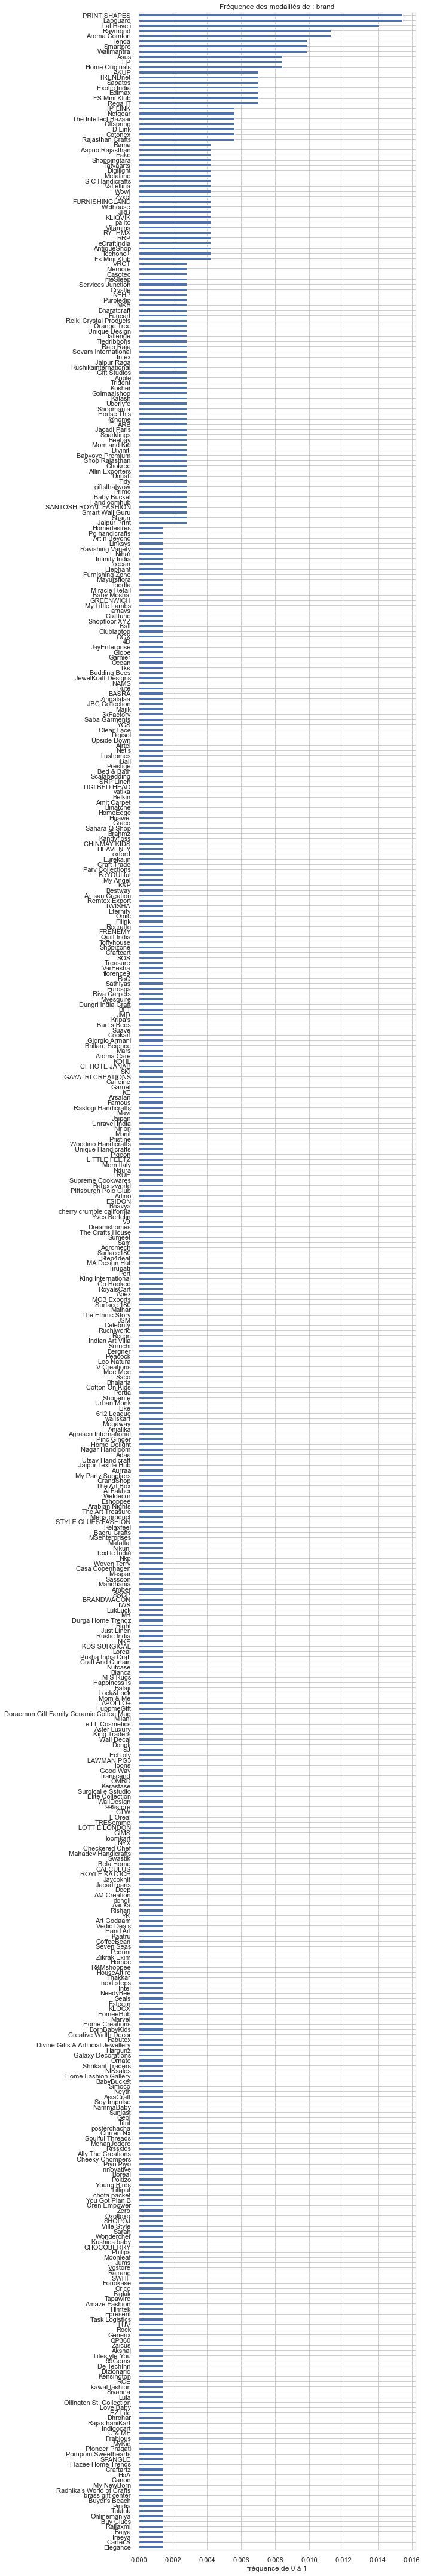

In [48]:
for column in ['brand']:
    chaine = 'Fréquence des modalités de : ' + column
    plt.figure(figsize=(10, 60))
    data[column].value_counts(normalize=True, ascending=True).plot(
        kind='barh')  # normalize pour avoir les fréquences
    plt.title(chaine)
    plt.xlabel("fréquence de 0 à 1")
    plt.tight_layout()

    # scaling automatique selon type de présentation ('notebook', 'paper', 'talk', 'poster')
    sns.set_context("notebook")

    plt.show()

La colonne 'brand' n'est pas très informative : néanmoins, à titre de **vérification**, on peut constater que l'une des **catégories** les **plus citées** correspond bien aux **marques** figurant parmi les **plus citées** : 
-  Print Shapes, Lapguard, HP, ASUS et Smartpro pour la catégorie **Laptop Accessories**.
-  **Wrist Watches** contient quant à elle beaucoup d'articles sans information dans le champ 'brand'.

In [49]:
data.loc[data['cat_2'] == 'Laptop Accessories', :]['brand'].unique()

array(['JRB', 'FRENEMY', 'Smartpro', 'Hako', 'Lapguard', 'HP', 'ARB',
       '4D', 'Clublaptop', 'Rega IT', 'Shopfloor.XYZ', 'Sunlast',
       'Pindia', 'Casotec', 'Fonokase', 'Memore', 'Orico', 'Bigkik',
       'Tapawire', 'Crystle', 'Amaze Fashion', 'RRP', 'Techone+',
       'Himtek', 'KLIQVIK', 'Epresent', 'Task Logistics', 'LUV', 'Rock',
       'Generix', 'QP360', 'Zaicus', 'Akshaj', 'Lifestyle-You', '99Gems',
       'De TechInn', 'Dizionario', 'Kensington', 'RCE', 'APOLLO+',
       'PRINT SHAPES'], dtype=object)

Je ne retiens au final que **4 features** pour chaque individu : **description, image, cat_1, label** :

In [50]:
cols_to_keep = ['cat_1', 'image', 'description', 'label']

In [51]:
data = data.loc[:, cols_to_keep]

# | Images | Traitement données

## | Collecte des résultats des tests de feature extractor dans DataFrame

In [52]:
# Création d'un dataframe pour visaliser l'ARI selon le modèle d'extraction utilisé
data_type = pd.Series(['Image', 'Image', 'Texte', 'Texte',
                      'Texte', 'Texte', 'Texte', 'Texte', 'Texte', 'Txt+Img'])
data_technique = pd.Series(['SIFT', 'VGG16', 'BoW_Count', 'BoW_TF-idf',
                           'W2Vec', 'BertHF1', 'BertHF2', 'BertTF', 'USE', 'BoW_TF-idf+VGG16'])
data_acp = pd.Series(['Yes', 'Yes', 'Yes', 'Yes', 'Yes',
                     'Yes', 'Yes', 'Yes', 'Yes', 'Yes'])

frame = {'Type': data_type, 'Technique': data_technique, 'ACP': data_acp,
         'ARI': '', 'Silhouette': ''}

results = pd.DataFrame(frame)

## | Préparation du dataset

### Import du dataset

In [53]:
path = "D:/FORMATION OPENCLASSROOMS/2. PROJETS/P6_DeRosa_Sebastien/Images/"

# on prend les noms des photos dans le même ordre que dans le DataFrame
list_photos = data['image'].tolist()
# list_photos = [file for file in listdir(path)]

print(len(list_photos))

1050


In [54]:
list_photos[0:3]

['55b85ea15a1536d46b7190ad6fff8ce7.jpg',
 '7b72c92c2f6c40268628ec5f14c6d590.jpg',
 '64d5d4a258243731dc7bbb1eef49ad74.jpg']

### Vérification des labels des photos dans le DataFrame

In [55]:
data.shape

(1050, 4)

In [56]:
data.head(10).T

0  \
cat_1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     Home Furnishing   
image                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                55b85ea15a1536d46b7190ad6fff8ce7.jpg   
description  Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you get the right amount of sunlight.,Specifications of Elegance Polyester Multicolor Abstract Eyelet Door Curta

### Affichage d'exemples d'images par champs cat_1 et image

Home Furnishing


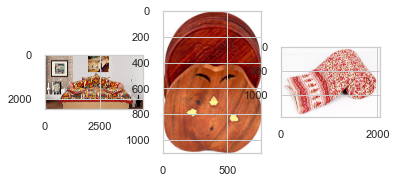

Baby Care


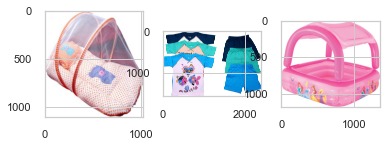

Watches


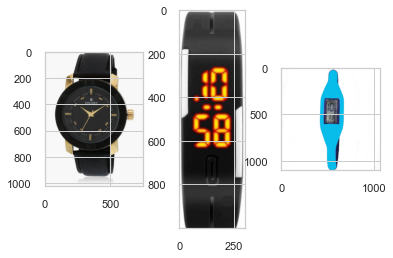

In [57]:
list_labels = ["Home Furnishing", "Baby Care", "Watches"]

for name in list_labels :
    print(name)
    # print("-------")
    for i in range(3):
        plt.subplot(130 + 1 + i)
        filename = path + list_fct(name)[i+10]
        image = imread(filename)
        plt.imshow(image)
    plt.show()

### Détermination et affichage des descripteurs SIFT

* L'image contient 47651 descripteurs
* Chaque descripteur est un vecteur de longueur 128

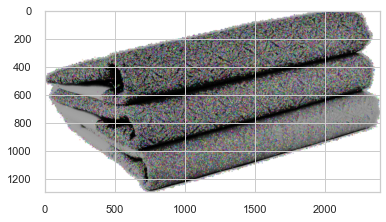

Descripteurs :  (47651, 128)

[[ 85. 113.  31. ...   0.   0.   0.]
 [ 29.  80.  73. ...   0.   0.   0.]
 [ 10.  67. 115. ...   0.   0.  22.]
 ...
 [  0.   0.   0. ...   0.   0.  13.]
 [ 40.   0.   0. ...   0.   0.  51.]
 [ 37.   1.   0. ...   0.   0.   0.]]


In [58]:
sift = cv2.xfeatures2d.SIFT_create()
image = cv2.imread(path+list_photos[1],0) # convert in gray
image = cv2.equalizeHist(image)   # equalize image histogram
kp, des = sift.detectAndCompute(image, None)
img=cv2.drawKeypoints(image,kp,image)
plt.imshow(img)
plt.show()
print("Descripteurs : ", des.shape)
print()
print(des)

## | Traitement SIFT

### Pré-traitement des images via SIFT | Créations des descripteurs de chaque image

* Pour chaque image passage en gris et equalisation
* création d'une liste de descripteurs par image ("sift_keypoints_by_img") qui sera utilisée pour réaliser les histogrammes par image
* création d'une liste de descripteurs pour l'ensemble des images ("sift_keypoints_all") qui sera utilisé pour créer les clusters de descripteurs

In [59]:
# identification of key points and associated descriptors
sift_keypoints = []
temps1=time.time()
sift = cv2.xfeatures2d.SIFT_create(500)

for image_num in range(len(list_photos)) :
    if image_num%100 == 0 : print(image_num)
    image = cv2.imread(path+list_photos[image_num],0) # convert in gray
    # image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    res = cv2.equalizeHist(image)   # equalize image histogram
    kp, des = sift.detectAndCompute(res, None)
    sift_keypoints.append(des)

sift_keypoints_by_img = np.asarray(sift_keypoints)
sift_keypoints_all    = np.concatenate(sift_keypoints_by_img, axis=0)

print()
print("Nombre de descripteurs : ", sift_keypoints_all.shape)

duration1=time.time()-temps1
print("temps de traitement SIFT descriptor : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000


C:\Users\sebas\AppData\Local\Temp\ipykernel_17928\2515362452.py:14: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.




Nombre de descripteurs :  (517351, 128)
temps de traitement SIFT descriptor :           287.95 secondes


### Pré-traitement des images via SIFT | Création des clusters de descripteurs
* Utilisation de MiniBatchKMeans pour obtenir des temps de traitement raisonnables

In [60]:
# Determination number of clusters
temps1=time.time()

k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(sift_keypoints_all)

duration1=time.time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  719
Création de 719 clusters de descripteurs ...
temps de traitement kmeans :             7.99 secondes


### Pré-traitement des images via SIFT | Création des features des images
* Pour chaque image : 
   - prédiction des numéros de cluster de chaque descripteur
   - création d'un histogramme = comptage pour chaque numéro de cluster du nombre de descripteurs de l'image

Features d'une image = Histogramme d'une image = Comptage pour une image du nombre de descripteurs par cluster

In [61]:
# Creation of histograms (features)
temps1=time.time()

# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(sift_keypoints_by_img) :
    if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1=time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")


0
100
200
300
400
500
600
700
800
900
1000
temps de création histogrammes :             4.65 secondes


In [62]:
im_features.shape

(1050, 719)

### SIFT | Application des fonctions ARI et TSNE_visu_fct sur im_features

In [63]:
l_cat = list(set(data['cat_1']))
y_cat_num = list(data['label'])

In [64]:
data.label

0       4
1       0
2       0
3       4
4       4
       ..
1045    0
1046    0
1047    0
1048    0
1049    0
Name: label, Length: 1050, dtype: int32

In [65]:
ARI, X_tsne, labels = ARI_fct(im_features)

C:\anaconda\envs\ml1\lib\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



ARI :  0.0412 time :  6.0


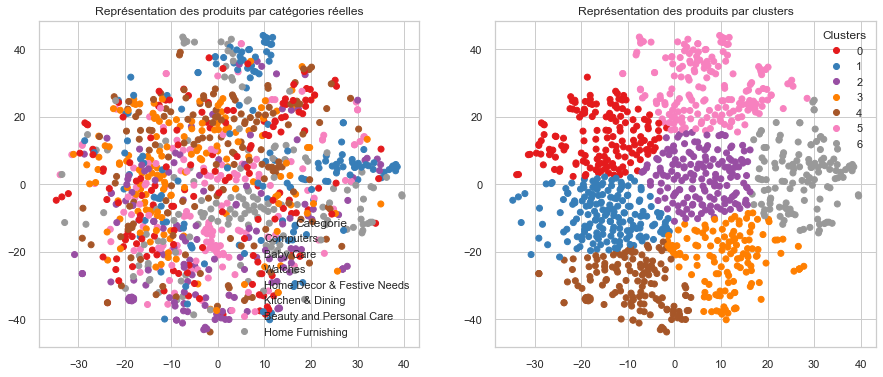

ARI :  0.0412


In [66]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

### SIFT | Réduction de dimension PCA

* La réduction PCA permet de **créer des features décorrélées** entre elles, et de **diminuer leur dimension**, tout en gardant un **niveau de variance expliquée** relativement **élevé** (99%)
* L'impact est une **meilleure séparation** des données via le T-SNE et une **réduction du temps de traitement** du T-SNE

In [67]:
print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 719)
Dimensions dataset après réduction PCA :  (1050, 498)


### SIFT | Application des fonctions ARI / TSNE_visu_fct / silh_fct sur feat_pca (après réduction pca)

In [68]:
ARI, X_tsne, labels = ARI_fct(feat_pca)

C:\anaconda\envs\ml1\lib\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



ARI :  0.0496 time :  5.0


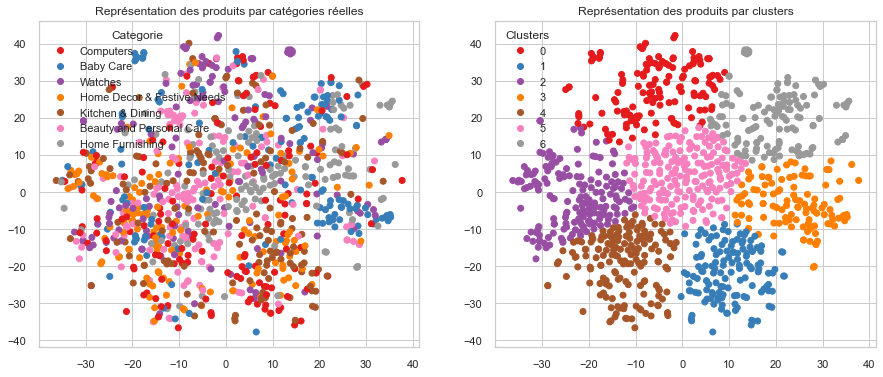

ARI :  0.0496


In [69]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

A droite on ne **peut pas réaliser de bonne estimation** via la méthode testée, car **la matrice** à laquelle on aboutit après **transformation SIFT ne permet pas** de capter la **réalité des catégories de produits** : à gauche on ne distingue aucun nuage consistant de points pouvant évoquer des clusters.<br>
Par conséquent, la **clusterisation k-means** à droite essaye de trouver des clusters par proximité, mais cette division n'a aucune probabilité de coincider avec la vision de gauche.

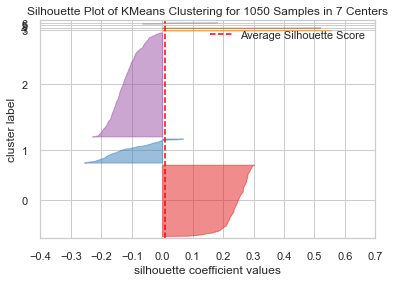

Silhouette Score :  0.0078 time :  0.0


In [70]:
silh = silh_fct(feat_pca)

In [71]:
results.loc[results["Technique"]=='SIFT','ARI'] = round(ARI,4)

In [72]:
results.loc[results["Technique"]=='SIFT','Silhouette'] = round(silh,4)

In [73]:
results

Type         Technique  ACP     ARI Silhouette
0    Image              SIFT  Yes  0.0496     0.0078
1    Image             VGG16  Yes                   
2    Texte         BoW_Count  Yes                   
3    Texte        BoW_TF-idf  Yes                   
4    Texte             W2Vec  Yes                   
5    Texte           BertHF1  Yes                   
6    Texte           BertHF2  Yes                   
7    Texte            BertTF  Yes                   
8    Texte               USE  Yes                   
9  Txt+Img  BoW_TF-idf+VGG16  Yes

### SIFT | Analyse par classes
* La matrice de confusion doit avoir en colonne le même ordre des catégories supposées qu'en ligne

In [74]:
df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["cat_1"]
df_tsne["cluster"] = labels
print(df_tsne.shape)

(1050, 4)


In [75]:
df_tsne.groupby("cluster").count()["class"]

cluster
0    142
1    133
2    170
3    116
4    164
5    194
6    131
Name: class, dtype: int64

In [76]:
conf_mat = metrics.confusion_matrix(y_cat_num, labels)
print(conf_mat)

[[19 36 25 11 32 14 13]
 [21  4 15 42 15 16 37]
 [43  7 31  9 16 17 27]
 [ 5 29 42  8 36 19 11]
 [16 46 22  8 20 25 13]
 [26  6 26 10 32 43  7]
 [12  5  9 28 13 60 23]]


In [77]:
np.unique(y_cat_num)

array([0, 1, 2, 3, 4, 5, 6])

In [78]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5, 6])

In [79]:
list_labels = data["cat_1"].unique()

<AxesSubplot:>

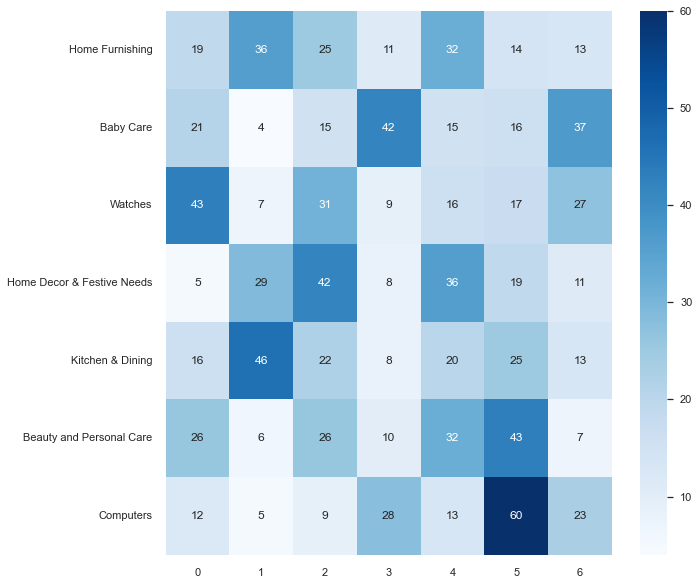

In [80]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in range(7)])
plt.figure(figsize = (10,10))
sns.heatmap(df_cm, annot=True, cmap="Blues")

## | Traitement VGG16

### VGG16 | Préparation des images et construction des vecteurs

In [81]:
# Change input shape dimensions for fine-tuning with Keras
model = VGG16(weights="imagenet", include_top=False,
              input_shape=(128, 128, 3))
model = Model(inputs = model.input, outputs = model.output)

In [82]:
image

array([[230, 230, 230, ..., 230, 230, 230],
       [228, 228, 228, ..., 228, 228, 228],
       [227, 227, 227, ..., 227, 227, 227],
       ...,
       [162, 167, 174, ..., 227, 227, 227],
       [163, 168, 175, ..., 228, 228, 228],
       [163, 168, 176, ..., 229, 229, 229]], dtype=uint8)

In [83]:
# apply VGG16 model to images and retrieve corresponding vectors
import time, cv2
vgg_pred = []
temps1=time.time()

for image_num in range(len(list_photos)) :

    if image_num%10 == 0 : print(image_num)
    image = cv2.imread(path+list_photos[image_num])
#     image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY) # convert in gray
#     res = cv2.equalizeHist(image)   # equalize image histogram
    res = cv2.resize(image, (128, 128)) # resize image
    res = res / 255.
    print(res.shape)
    res = np.expand_dims(res, axis=0)
#     res = np.expand_dims(res, axis=-1)
    features = model.predict(res)
    vgg_pred.append(features.flatten())


vgg_pred = np.array(vgg_pred)

print()
print("Nombre de vecteurs : ", vgg_pred.shape)

duration1=time.time()-temps1
print("temps de traitement VGG16 : ", "%15.2f" % duration1, "secondes")

0
(128, 128, 3)
1/1 [==============================] - 0s 419ms/step
(128, 128, 3)
1/1 [==============================] - 0s 46ms/step
(128, 128, 3)
1/1 [==============================] - 0s 45ms/step
(128, 128, 3)
1/1 [==============================] - 0s 46ms/step
(128, 128, 3)
1/1 [==============================] - 0s 46ms/step
(128, 128, 3)
1/1 [==============================] - 0s 48ms/step
(128, 128, 3)
1/1 [==============================] - 0s 46ms/step
(128, 128, 3)
1/1 [==============================] - 0s 45ms/step
(128, 128, 3)
1/1 [==============================] - 0s 45ms/step
(128, 128, 3)
1/1 [==============================] - 0s 44ms/step
10
(128, 128, 3)
1/1 [==============================] - 0s 45ms/step
(128, 128, 3)
1/1 [==============================] - 0s 43ms/step
(128, 128, 3)
1/1 [==============================] - 0s 44ms/step
(128, 128, 3)
1/1 [==============================] - 0s 45ms/step
(128, 128, 3)
1/1 [==============================] - 0s 47ms/step
(128

**vgg_pred** : ligne = instance / colonnes = features.

In [84]:
features.flatten().shape

(8192,)

In [85]:
print(res.shape)

(1, 128, 128, 3)


In [86]:
print(vgg_pred.shape)

(1050, 8192)


### VGG16 | Application des fonctions ARI / TSNE_visu_fct / silh_fct sur vgg_pred

In [87]:
ARI, X_tsne, labels = ARI_fct(vgg_pred)

C:\anaconda\envs\ml1\lib\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



ARI :  0.2571 time :  6.0


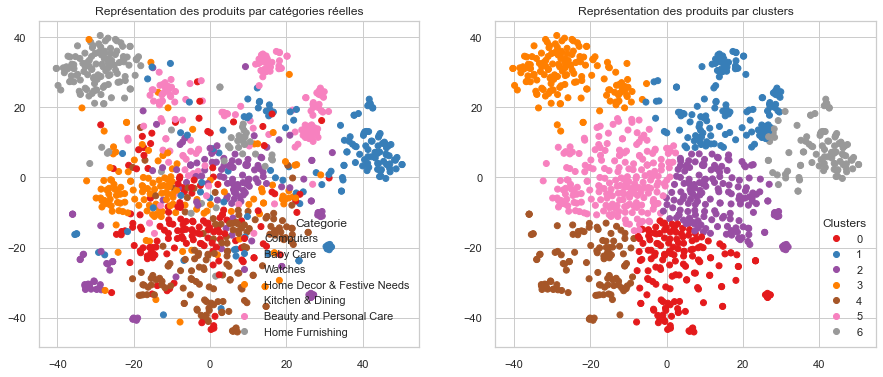

ARI :  0.2571


In [88]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

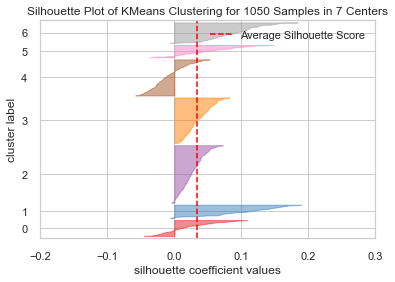

Silhouette Score :  0.034 time :  3.0


In [89]:
silh = silh_fct(vgg_pred)

In [90]:
results.loc[results["Technique"]=='VGG16','Silhouette'] = round(silh,4)

In [91]:
results.loc[results["Technique"]=='VGG16','ARI'] = round(ARI,4)

In [92]:
results

Type         Technique  ACP     ARI Silhouette
0    Image              SIFT  Yes  0.0496     0.0078
1    Image             VGG16  Yes  0.2571      0.034
2    Texte         BoW_Count  Yes                   
3    Texte        BoW_TF-idf  Yes                   
4    Texte             W2Vec  Yes                   
5    Texte           BertHF1  Yes                   
6    Texte           BertHF2  Yes                   
7    Texte            BertTF  Yes                   
8    Texte               USE  Yes                   
9  Txt+Img  BoW_TF-idf+VGG16  Yes

# | Texte | Traitement données

## | Sentence Embedding - Présentation générale

* Afin de gagner du temps j'ai partiellement réutilisé et personalisé un notebook fourni qui présente différentes techniques de "Sentence Embeddings", permettant de générer des features à partir de phrases (à l'origine des tweets).
* L'objectif est de pouvoir présenter des catégories ou clusters issus d'un k-means de façon automatique, via un T-SNE, qui permet une réduction des features en 2 dimensions.
* le notebook d'exemples a été adapté à ce nouveau contexte, en particulier sur les points suivants :
    * Le nettoyage des textes
    * les modèles BERT (model_type)
    * La taille des vecteurs (max_length)
    * Le batch_size
    * La perplexité du Tsne (perplexity à 30 par défaut)

## | Préparation initiale dataset et sauvegarde csv

### Test des fonctions textuelles

In [93]:
test_text = """With just under a month until the transfer window closes, Cristiano Ronaldo's chances 
of leaving Manchester United continue to diminish! He's made it clear : he wants to leave for a new 
side (the Red Devils failed to qualify for the Champions League) but so far, they've refused every 
offer made for the Portuguese star. #goodluckcr7"""

In [94]:
test_text

"With just under a month until the transfer window closes, Cristiano Ronaldo's chances \nof leaving Manchester United continue to diminish! He's made it clear : he wants to leave for a new \nside (the Red Devils failed to qualify for the Champions League) but so far, they've refused every \noffer made for the Portuguese star. #goodluckcr7"

In [95]:
test_token = tokenizer_fct(test_text)
print('len:',len(test_token))
test_token

len: 65


['With',
 'just',
 'under',
 'a',
 'month',
 'until',
 'the',
 'transfer',
 'window',
 'closes',
 ',',
 'Cristiano',
 'Ronaldo',
 "'s",
 'chances',
 'of',
 'leaving',
 'Manchester',
 'United',
 'continue',
 'to',
 'diminish',
 '!',
 'He',
 "'s",
 'made',
 'it',
 'clear',
 ':',
 'he',
 'wants',
 'to',
 'leave',
 'for',
 'a',
 'new',
 'side',
 '(',
 'the',
 'Red',
 'Devils',
 'failed',
 'to',
 'qualify',
 'for',
 'the',
 'Champions',
 'League',
 ')',
 'but',
 'so',
 'far',
 ',',
 'they',
 "'ve",
 'refused',
 'every',
 'offer',
 'made',
 'for',
 'the',
 'Portuguese',
 'star',
 '.',
 'goodluckcr7']

In [96]:
test_stop = stop_word_filter_fct(test_token)
print('len:',len(test_stop))
test_stop

len: 34


['With',
 'month',
 'transfer',
 'window',
 'closes',
 'Cristiano',
 'Ronaldo',
 'chances',
 'leaving',
 'Manchester',
 'United',
 'continue',
 'diminish',
 'made',
 'clear',
 'wants',
 'leave',
 'new',
 'side',
 'Red',
 'Devils',
 'failed',
 'qualify',
 'Champions',
 'League',
 'far',
 "'ve",
 'refused',
 'every',
 'offer',
 'made',
 'Portuguese',
 'star',
 'goodluckcr7']

In [97]:
test_lower = lower_start_fct(test_stop)
print('len:',len(test_lower))
test_lower

len: 34


['with',
 'month',
 'transfer',
 'window',
 'closes',
 'cristiano',
 'ronaldo',
 'chances',
 'leaving',
 'manchester',
 'united',
 'continue',
 'diminish',
 'made',
 'clear',
 'wants',
 'leave',
 'new',
 'side',
 'red',
 'devils',
 'failed',
 'qualify',
 'champions',
 'league',
 'far',
 "'ve",
 'refused',
 'every',
 'offer',
 'made',
 'portuguese',
 'star',
 'goodluckcr7']

In [98]:
test_lemma = lemma_fct(test_lower)
print('len:',len(test_lemma))
test_lemma

len: 34


['with',
 'month',
 'transfer',
 'window',
 'close',
 'cristiano',
 'ronaldo',
 'chance',
 'leaving',
 'manchester',
 'united',
 'continue',
 'diminish',
 'made',
 'clear',
 'want',
 'leave',
 'new',
 'side',
 'red',
 'devil',
 'failed',
 'qualify',
 'champion',
 'league',
 'far',
 "'ve",
 'refused',
 'every',
 'offer',
 'made',
 'portuguese',
 'star',
 'goodluckcr7']

In [99]:
test_join = ' '.join(test_lemma)
test_join

"with month transfer window close cristiano ronaldo chance leaving manchester united continue diminish made clear want leave new side red devil failed qualify champion league far 've refused every offer made portuguese star goodluckcr7"

### Transformations pour Bag of Words / Deep Learning et sauvegarde en csv

Selon les besoins des différents feature extractors, je vais créer des **features dérivées de 'description'** en utilisant des fonctions qui **enchainent** plus ou moins ces différentes **étapes de traitement de texte**, puis **sauvegarder en csv** pour utilisation future par les différents extractors :

In [100]:
data['description_bow'] = data['description'].apply(lambda x : transform_bow_fct(x))
data['description_bow_lem'] = data['description'].apply(lambda x : transform_bow_lem_fct(x))
data['description_dl'] = data['description'].apply(lambda x : transform_dl_fct(x))
data.shape

(1050, 7)

In [101]:
data.head(3)

cat_1                                 image  \
0  Home Furnishing  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1        Baby Care  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2        Baby Care  64d5d4a258243731dc7bbb1eef49ad74.jpg   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    description  \
0  Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you get the right amount of sunlight.,Specifications of Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) General Brand Elegance Designed For Door Type Eyelet Model Name Abstract Polyester Door Curtain Set Of 2 Model ID Duster25 Color Multicolor Dimensions Length 213 cm In the Box Number of Contents in Sales Package Pack of 2 Sales Package 2 Curtains Body & Design Material Polyester   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [102]:
data.to_csv("data_prep_text.csv")

## | Préparation commune des traitements

### Lecture dataset

In [103]:
data_T =  pd.read_csv("data_prep_text.csv")
print(data_T.shape)

(1050, 8)


### Identification des catégories et listes

In [104]:
l_cat = list(set(data_T['cat_1']))
print("catégories : ", l_cat)
y_cat_num = [(1-l_cat.index(data_T.iloc[i]['cat_1'])) for i in range(len(data_T))]

catégories :  ['Computers', 'Baby Care', 'Watches', 'Home Decor & Festive Needs', 'Kitchen & Dining', 'Beauty and Personal Care', 'Home Furnishing']


In [105]:
list_set=set(y_cat_num)
unique_list = (list(list_set))
unique_list

[0, 1, -2, -5, -4, -3, -1]

### Tokenisation

In [106]:
data_T['length_bow'] = data_T['description_bow'].apply(lambda x : len(word_tokenize(x)))
print("max length bow : ", data_T['length_bow'].max())
data_T['length_dl'] = data_T['description_dl'].apply(lambda x : len(word_tokenize(x)))
print("max length dl : ", data_T['length_dl'].max())


max length bow :  379
max length dl :  632


## | Bag of word - Tf-idf (Term Frequency-Inverse Document Frequency)

### Préparation sentences

In [107]:
# création du bag of words (CountVectorizer et Tf-idf)

cvect = CountVectorizer(stop_words='english', max_df=0.95, min_df=1)
ctf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1)

feat = 'description_bow_lem'
cv_fit = cvect.fit(data_T[feat])
ctf_fit = ctf.fit(data_T[feat])

cv_transform = cvect.transform(data_T[feat])  
ctf_transform = ctf.transform(data_T[feat])  

In [108]:
cv_transform

<1050x5324 sparse matrix of type '<class 'numpy.int64'>'
	with 34179 stored elements in Compressed Sparse Row format>

In [109]:
ctf_transform

<1050x5324 sparse matrix of type '<class 'numpy.float64'>'
	with 34179 stored elements in Compressed Sparse Row format>

In [110]:
len(y_cat_num)

1050

### Exécution des modèles

In [111]:
print("CountVectorizer : ")
print("-----------------")
cv_transform = cv_transform.todense()
ARI, X_tsne, labels = ARI_fct(cv_transform)
results.loc[results["Technique"]=='BoW_Count','ARI'] = round(ARI,4)
print()
print("Tf-idf : ")
print("--------")
ctf_transform = ctf_transform.todense()
ARI_1, X_tsne_1, labels_1 = ARI_fct(ctf_transform)
results.loc[results["Technique"]=='BoW_TF-idf','ARI'] = round(ARI_1,4)

CountVectorizer : 
-----------------


C:\anaconda\envs\ml1\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html

C:\anaconda\envs\ml1\lib\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



ARI :  0.4328 time :  6.0

Tf-idf : 
--------


C:\anaconda\envs\ml1\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html

C:\anaconda\envs\ml1\lib\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



ARI :  0.5274 time :  5.0


### Graphiques

Avec l'outil **CountVectorizer** :

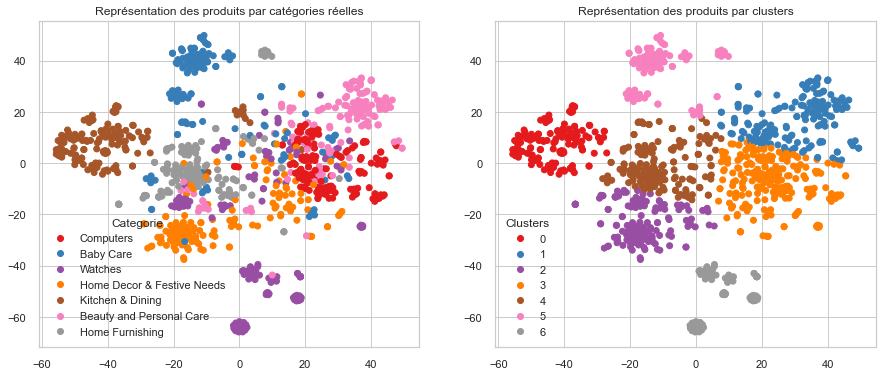

ARI :  0.4328


In [112]:
 TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

C:\anaconda\envs\ml1\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html

C:\anaconda\envs\ml1\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html

C:\anaconda\envs\ml1\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html

C:\anaconda\envs\ml1\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning:

np.

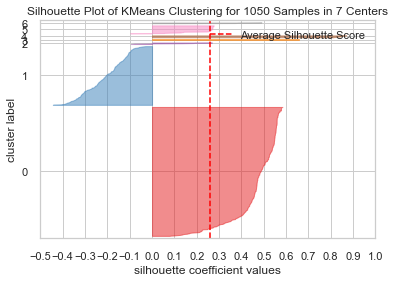

Silhouette Score :  0.2615 time :  1.0


In [113]:
silh = silh_fct(cv_transform)

In [114]:
results.loc[results["Technique"]=='BoW_Count','Silhouette'] = round(silh,4)

Avec l'outil **Tf-idf** :

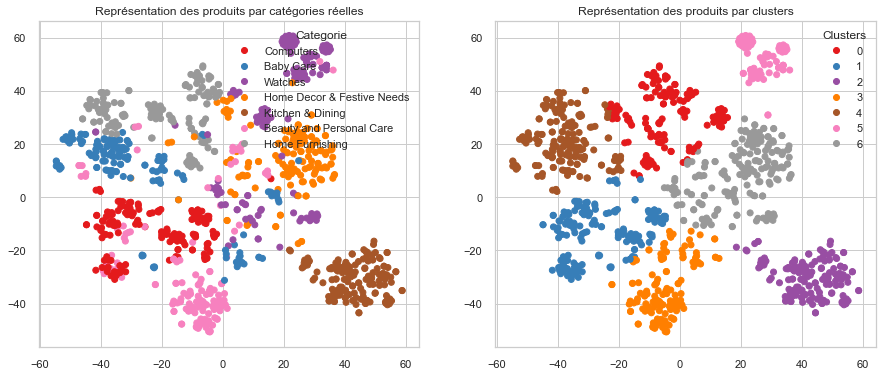

ARI :  0.5274


In [115]:
 TSNE_visu_fct(X_tsne_1, y_cat_num, labels_1, ARI_1)

C:\anaconda\envs\ml1\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html

C:\anaconda\envs\ml1\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html

C:\anaconda\envs\ml1\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html

C:\anaconda\envs\ml1\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning:

np.

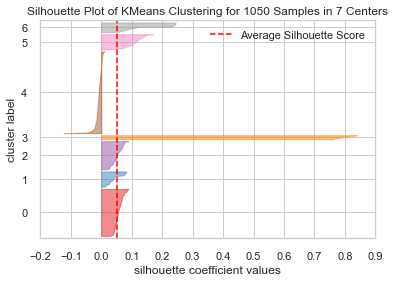

Silhouette Score :  0.0517 time :  1.0


In [116]:
silh = silh_fct(ctf_transform)

In [117]:
results.loc[results["Technique"]=='BoW_TF-idf','Silhouette'] = round(silh,4)

## | Word2Vec

### Création du modèle Word2Vec

**Recherche du plus grand nombre de mots :**

In [118]:
lengths = data_T['description_bow_lem'].str.len()
argmax = np.where(lengths == lengths.max())[0]
data_T.iloc[argmax]['description_bow_lem']

437    key feature homeedge solid wood king bed king bed 72x78 mattress size king bed natural polish homeedge solid wood king bed finish color natural price 18,799 made order solidwood bed made finest artisan rajasthan bed made perfection these bed handicraft product made order manufacturer please make sure bed ordered aware entire product mattress dimension queen size bed 60inch 78inch mattress dimension king bed 72inch 78inch kindly check mattress size order bed also polish might slight variation wooden product grain uniform due grain polish might look light dark portion all wooden product termite treated gone high level quality check packed. specification homeedge solid wood king bed finish color natural installation demo installation demo detail installation demo product done free cost part purchase our service partner visit location within business hour delivery product the box king bed general brand homeedge delivery condition knock down storage included style contemporary modern

In [119]:
# initialize string
text = str(data_T.iloc[argmax]['description_bow_lem'])

# default separator: space
result = len(text.split())

print("There are " + str(result) + " words.")

There are 383 words.


In [120]:
w2v_size=300
w2v_window=5
w2v_min_count=1
w2v_epochs=100
maxlen = 383 # adapt to length of sentences
sentences = data_T['description_bow_lem'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [121]:
# Création et entraînement du modèle Word2Vec

print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=42,
                                                workers=1)
#                                                workers=multiprocessing.cpu_count())
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 4712
Word2Vec trained


In [122]:
# Préparation des sentences (tokenization)

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 4713


### Création de la matrice d'embedding

In [123]:
# Création de la matrice d'embedding

print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (4713, 300)


### Création du modèle d'embedding

In [124]:
# Création du modèle

input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 383)]             0         
                                                                 
 embedding (Embedding)       (None, 383, 300)          1413900   
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 1,413,900
Trainable params: 1,413,900
Non-trainable params: 0
_________________________________________________________________


### Exécution du modèle

In [125]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

33/33 [==============================] - 0s 3ms/step


(1050, 300)

In [126]:
ARI, X_tsne, labels = ARI_fct(embeddings)

C:\anaconda\envs\ml1\lib\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



ARI :  0.3215 time :  5.0


In [127]:
results.loc[results["Technique"]=='W2Vec','ARI'] = round(ARI,4)

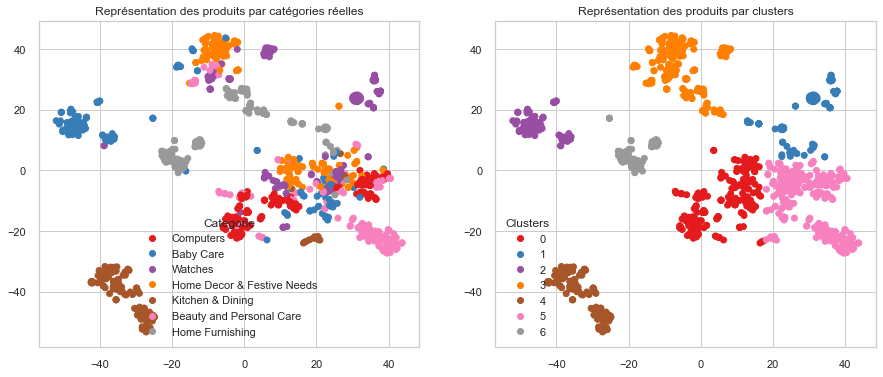

ARI :  0.3215


In [128]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

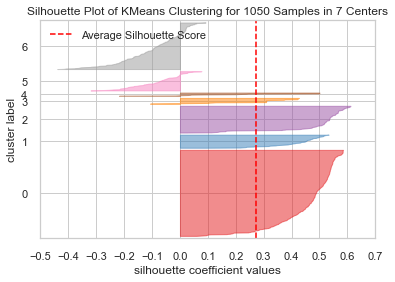

Silhouette Score :  0.2717 time :  0.0


In [129]:
silh = silh_fct(embeddings)

In [130]:
results.loc[results["Technique"]=='W2Vec','Silhouette'] = round(silh,4)

## | BERT

### BERT Vérifications de version

In [131]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.9.1
2.9.1
Num GPUs Available:  0
True


### BERT HuggingFace

#### 'bert-base-uncased'

In [132]:
max_length = 383
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
sentences = data_T['description_dl'].to_list()

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at C:\Users\sebas/.cache\huggingface\transformers\3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.20.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-base-u

In [133]:
# Création des features

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='HF')

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at C:\Users\sebas/.cache\huggingface\transformers\3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.20.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/bert-base-uncased/r

1/1 [==============================] - 3s 3s/step
temps traitement :  351.0


In [134]:
features_bert.shape

(1050, 768)

In [135]:
ARI, X_tsne, labels = ARI_fct(features_bert)

C:\anaconda\envs\ml1\lib\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



ARI :  0.293 time :  5.0


In [136]:
results.loc[results["Technique"]=='BertHF1','ARI'] = round(ARI,4)

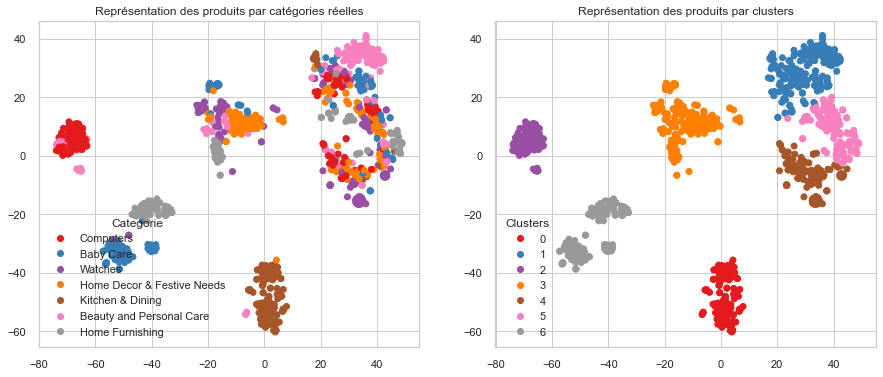

ARI :  0.293


In [137]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

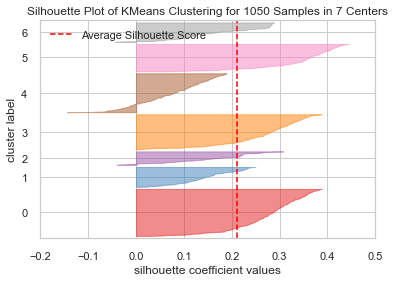

Silhouette Score :  0.2114 time :  0.0


In [138]:
silh = silh_fct(features_bert)

In [139]:
results.loc[results["Technique"]=='BertHF1','Silhouette'] = round(silh,4)

#### 'cardiffnlp/twitter-roberta-base-sentiment'
* Modèle pré-entraîné sur des tweets pour l'analyse de sentiment = pas vraiment adapté au contexte

In [140]:
max_length = 383
batch_size = 10
model_type = 'cardiffnlp/twitter-roberta-base-sentiment'
model = TFAutoModel.from_pretrained(model_type)
sentences = data_T['description_dl'].to_list()

loading configuration file https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment/resolve/main/config.json from cache at C:\Users\sebas/.cache\huggingface\transformers\7dd97280b5338fb674b5372829a05a1aaaa76f9f2fa71c36199f2ce1ee1104a0.4c7ca95b4fd82b8bbe94fde253f5f82e5a4eedefe6f86f6fa79efc903d6cfe60
Model config RobertaConfig {
  "_name_or_path": "cardiffnlp/twitter-roberta-base-sentiment",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_atten

In [141]:
features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='HF')

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment/resolve/main/config.json from cache at C:\Users\sebas/.cache\huggingface\transformers\7dd97280b5338fb674b5372829a05a1aaaa76f9f2fa71c36199f2ce1ee1104a0.4c7ca95b4fd82b8bbe94fde253f5f82e5a4eedefe6f86f6fa79efc903d6cfe60
Model config RobertaConfig {
  "_name_or_path": "cardiffnlp/twitter-roberta-base-sentiment",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "laye

1/1 [==============================] - 3s 3s/step
temps traitement :  341.0


In [142]:
features_bert.shape

(1050, 768)

In [143]:
ARI, X_tsne, labels = ARI_fct(features_bert)

C:\anaconda\envs\ml1\lib\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



ARI :  0.1971 time :  5.0


In [144]:
results.loc[results["Technique"]=='BertHF2','ARI'] = round(ARI,4)

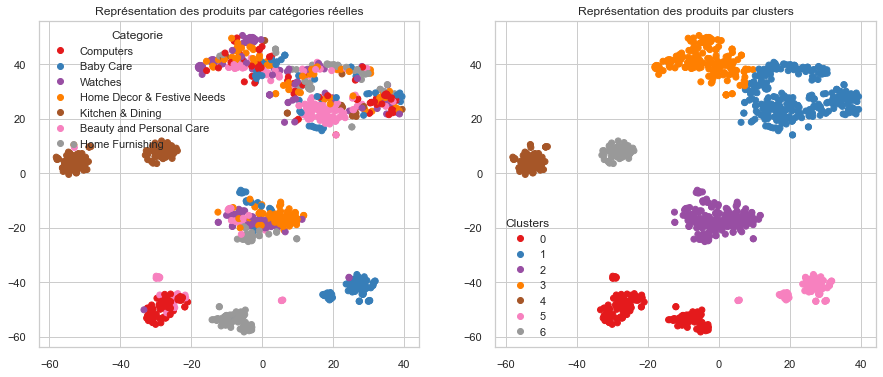

ARI :  0.1971


In [145]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

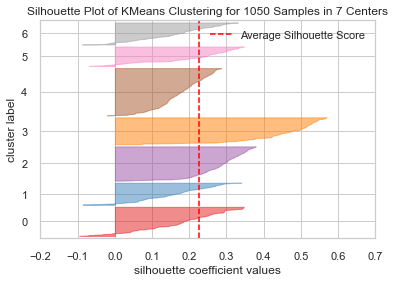

Silhouette Score :  0.2272 time :  0.0


In [146]:
silh = silh_fct(features_bert)

In [147]:
results.loc[results["Technique"]=='BertHF2','Silhouette'] = round(silh,4)

### BERT hub Tensorflow

In [148]:
os.getcwd()

'D:\\FORMATION OPENCLASSROOMS\\2. PROJETS\\P6_DeRosa_Sebastien'

In [149]:
# Guide sur le Tensorflow hub : https://www.tensorflow.org/text/tutorials/classify_text_with_bert
# Model saved and unzipped from https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4 on current folder
model_url = r'D:\\FORMATION OPENCLASSROOMS\\2. PROJETS\\P6_DeRosa_Sebastien\bert'
bert_layer = hub.KerasLayer(model_url, trainable=True)

In [150]:
sentences = data_T['description_dl'].to_list()

In [151]:
max_length = 383
batch_size = 10
model_type = 'bert-base-uncased'
model = bert_layer

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='TFhub')

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at C:\Users\sebas/.cache\huggingface\transformers\3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.20.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/bert-base-uncased/r

temps traitement :  361.0


In [152]:
features_bert.shape

(1050, 768)

In [153]:
ARI, X_tsne, labels = ARI_fct(features_bert)

C:\anaconda\envs\ml1\lib\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



ARI :  0.2935 time :  5.0


In [154]:
results.loc[results["Technique"]=='BertTF','ARI'] = round(ARI,4)

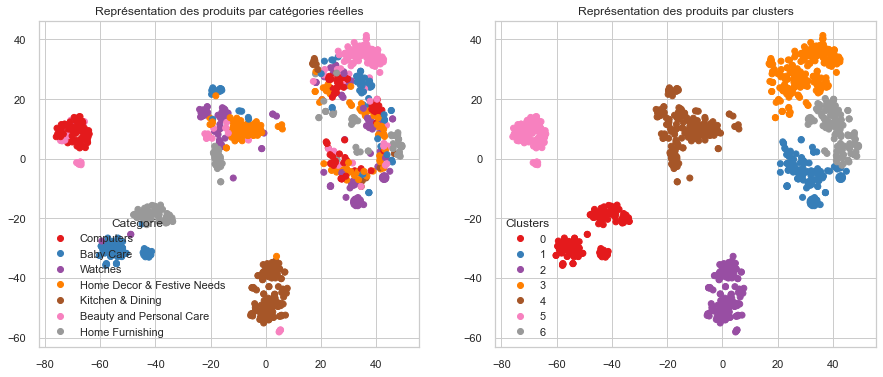

ARI :  0.2935


In [155]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

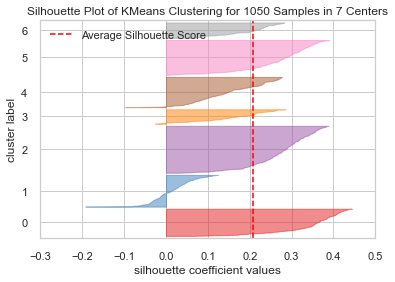

Silhouette Score :  0.2071 time :  0.0


In [156]:
silh = silh_fct(features_bert)

In [157]:
results.loc[results["Technique"]=='BertTF','Silhouette'] = round(silh,4)

## | USE - Universal Sentence Encoder

In [158]:
# Model saved and unzipped from 'https://tfhub.dev/google/universal-sentence-encoder/4' on current folder
# \U in "...\use starts an eight-character Unicode escape, such as \U00014321.
# In this code, the escape is followed by the character 's', which is invalid
# prefix the string with r (to produce a raw string) 
model_url = r'D:\\FORMATION OPENCLASSROOMS\\2. PROJETS\\P6_DeRosa_Sebastien\use'
embed = hub.load(model_url)

In [159]:
batch_size = 10
sentences = data_T['description_dl'].to_list()

In [160]:
features_USE = feature_USE_fct(sentences, batch_size)

In [161]:
features_USE.shape

(1050, 512)

In [162]:
ARI, X_tsne, labels = ARI_fct(features_USE)

C:\anaconda\envs\ml1\lib\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



ARI :  0.4336 time :  5.0


In [163]:
results.loc[results["Technique"]=='USE','ARI'] = round(ARI,4)

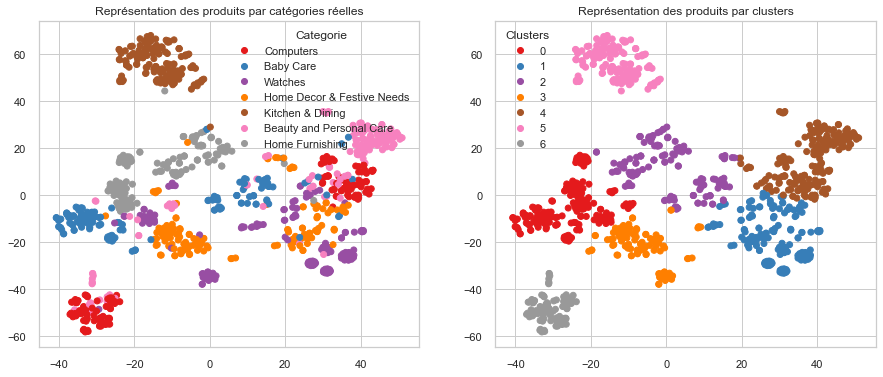

ARI :  0.4336


In [164]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

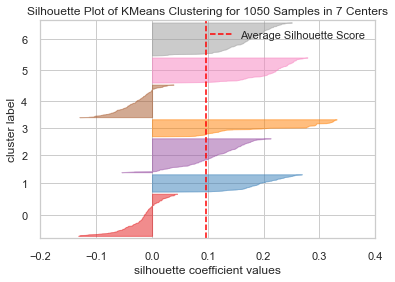

Silhouette Score :  0.0973 time :  0.0


In [165]:
silh = silh_fct(features_USE)

In [166]:
results.loc[results["Technique"]=='USE','Silhouette'] = round(silh,4)

# | Texte + Images | Concaténation des features

Lors des précédentes étapes on a pu identifier les meilleurs feature extractors de texte et d'image :
-  Texte : BoW_TF-idf
-  Image : VGG16

In [167]:
features_t_i = np.concatenate((vgg_pred, ctf_transform), axis=1)

* La réduction PCA permet de **créer des features décorrélées** entre elles, et de **diminuer leur dimension**, tout en gardant un **niveau de variance expliquée** relativement **élevé** (99%)
* L'impact est une **meilleure séparation** des données via le T-SNE et une **réduction du temps de traitement** du T-SNE

In [168]:
print("Dimensions dataset avant réduction PCA : ", features_t_i.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(features_t_i)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 13516)


C:\anaconda\envs\ml1\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html



Dimensions dataset après réduction PCA :  (1050, 873)


In [169]:
ARI, X_tsne, labels = ARI_fct(feat_pca)

C:\anaconda\envs\ml1\lib\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



ARI :  0.2582 time :  5.0


In [170]:
results.loc[results["Technique"]=='BoW_TF-idf+VGG16','ARI'] = round(ARI,4)

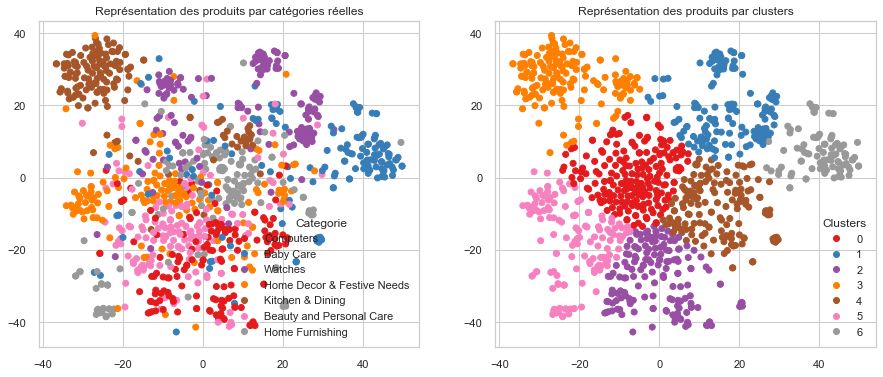

ARI :  0.2582


In [171]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

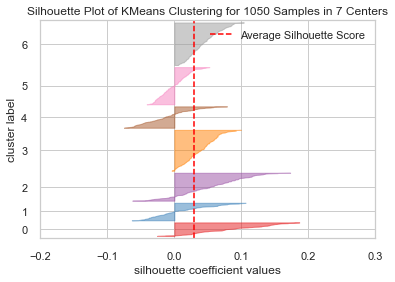

Silhouette Score :  0.0295 time :  0.0


In [172]:
silh = silh_fct(feat_pca)

In [173]:
results.loc[results["Technique"]=='BoW_TF-idf+VGG16','Silhouette'] = round(silh,4)

# | Comparaison des feature extractors

In [174]:
results.sort_values(by="ARI", ascending=False)

Type         Technique  ACP     ARI Silhouette
3    Texte        BoW_TF-idf  Yes  0.5274     0.0517
8    Texte               USE  Yes  0.4336     0.0973
2    Texte         BoW_Count  Yes  0.4328     0.2615
4    Texte             W2Vec  Yes  0.3215     0.2717
7    Texte            BertTF  Yes  0.2935     0.2071
5    Texte           BertHF1  Yes   0.293     0.2114
9  Txt+Img  BoW_TF-idf+VGG16  Yes  0.2582     0.0295
1    Image             VGG16  Yes  0.2571      0.034
6    Texte           BertHF2  Yes  0.1971     0.2272
0    Image              SIFT  Yes  0.0496     0.0078

<AxesSubplot:xlabel='Technique'>

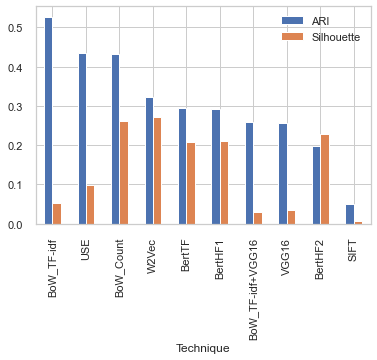

In [175]:
results.sort_values(by="ARI", ascending=False).plot(x='Technique', kind='bar')

**Conclusion et préconisation** :
-  selon **ARI Score** : utiliser l'extractor de **Texte BoW_TF-idf**
-  selon **Silhouette Score** : aucun modèle idéal, le **meilleur étant W2Vec**, mais le détail pour ce modèle montre **beaucoup de produits mal classés** et un **nombre de clusters non pertinent**.
-  essayer d’**améliorer le modèle VGG16** en l’**entrainant**
-  travailler avec le **second niveau** de la **hiérarchie** (en préparant un **échantillon adapté**, contenant **plus de produits** et des **catégories de taille identique**, pour permettre une **meilleure qualité** de reconnaissance et de **clusterisation**) 